### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


### load data

In [3]:
fraud_df = pd.read_csv(r"C:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\data\raw\Fraud_Data.csv")

# Quick overview
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


### Data Cleaning

In [4]:
fraud_df.isnull().sum()

# Remove duplicates
fraud_df.drop_duplicates(inplace=True)

# Impute missing values
fraud_df['age'] = fraud_df['age'].fillna(fraud_df['age'].median())
fraud_df['browser'] = fraud_df['browser'].fillna('Unknown')
fraud_df['sex'] = fraud_df['sex'].fillna('U')  # Unknown



### Correct Data Types

In [5]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['ip_address'] = fraud_df['ip_address'].astype(str)
fraud_df['class'] = fraud_df['class'].astype(int)

fraud_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  object        
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 12.7+ MB


### Exploratory Data Analysis (EDA)

### Univariate plots

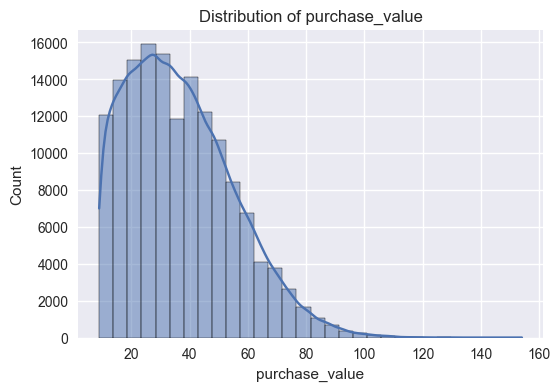

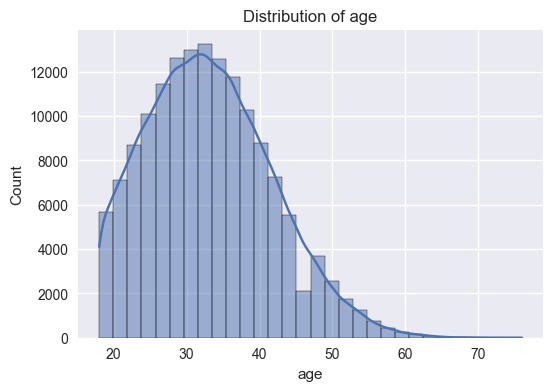

In [6]:
numerical_features = ['purchase_value', 'age']

for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.histplot(fraud_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

### Bivariate analysis: Purchase Value vs Class

#### Purchase Value vs Fraud

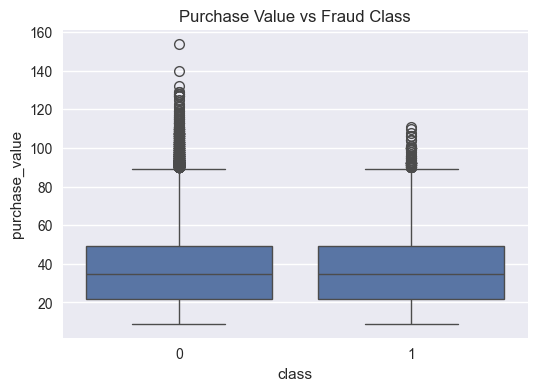

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value vs Fraud Class')
plt.show()


#### Age vs Fraud

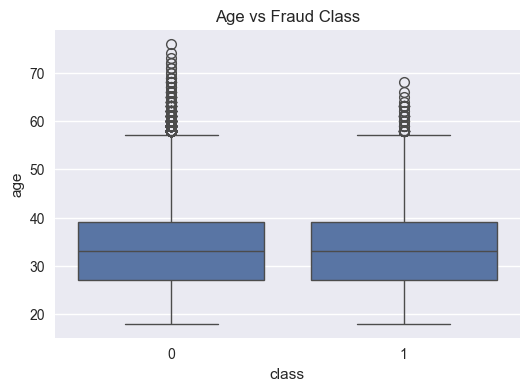

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x='class', y='age', data=fraud_df)
plt.title('Age vs Fraud Class')
plt.show()


### Class distribution

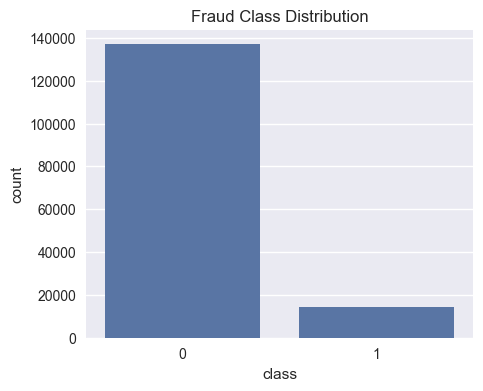

In [9]:
fraud_df['class'].value_counts()
plt.figure(figsize=(5,4))
sns.countplot(x='class', data=fraud_df)
plt.title('Fraud Class Distribution')
plt.show()


### Geolocation Integration

#### Load IP Dataset

In [10]:
ip_df = pd.read_csv(
    r"C:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\data\raw\IpAddress_to_Country.csv"
)

ip_df.head()


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


#### Convert IP Address to Integer

In [11]:
def ip_to_int(ip):
    try:
        parts = ip.split('.')
        return int(parts[0])*256**3 + int(parts[1])*256**2 + int(parts[2])*256 + int(parts[3])
    except:
        return np.nan

fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)


#### Range-Based Country Mapping

country
Unknown    0.093646
Name: class, dtype: float64


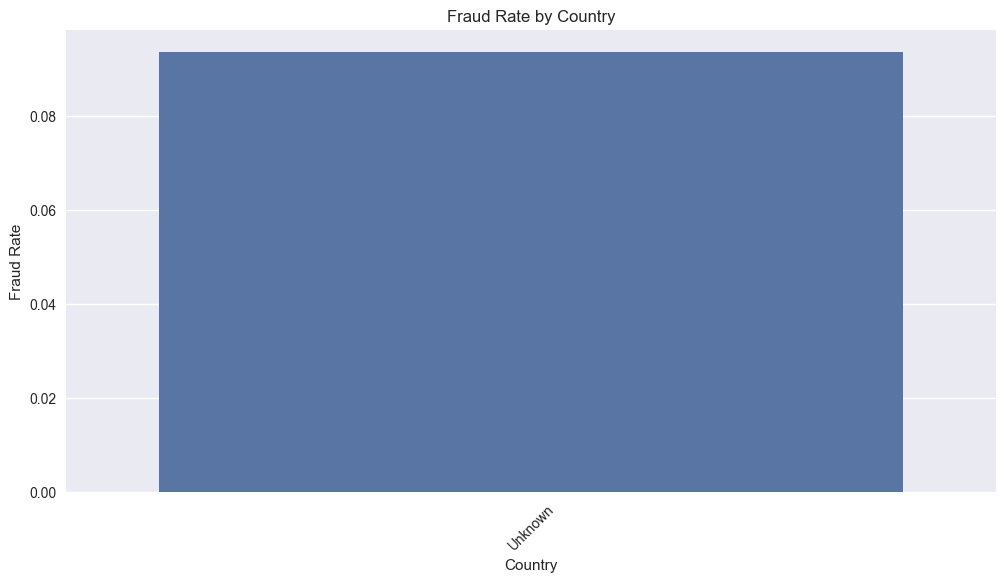

In [19]:
# Ensure IP range columns are integers
ip_df['range_start_int'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['range_end_int'] = ip_df['upper_bound_ip_address'].astype(int)

# Sort IP ranges for efficient lookup
ip_df = ip_df.sort_values('range_start_int').reset_index(drop=True)

# Function to map IP integer to country using vectorized approach
def map_country_vectorized(ip_series, ip_ranges_df):
    countries = []
    for ip in ip_series:
        row = ip_ranges_df[(ip_ranges_df['range_start_int'] <= ip) & (ip_ranges_df['range_end_int'] >= ip)]
        if not row.empty:
            countries.append(row['country'].values[0])
        else:
            countries.append('Unknown')
    return countries

# Apply mapping to fraud dataset
fraud_df['country'] = map_country_vectorized(fraud_df['ip_int'], ip_df)

# Visualize fraud rate by country
fraud_by_country = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)
print(fraud_by_country.head(10))

plt.figure(figsize=(12,6))
sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values)
plt.xticks(rotation=45)
plt.title('Fraud Rate by Country')
plt.ylabel('Fraud Rate')
plt.xlabel('Country')
plt.show()


### Feature Engineering

#### Time-Based Features

In [14]:
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds() / 3600  # hours

fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek


#### Transaction Frequency & Velocity

In [15]:
# Number of transactions per user
fraud_df['user_transaction_count'] = (
    fraud_df.groupby('user_id')['user_id'].transform('count')
)

# Average time gap between purchases per user
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time'])

fraud_df['time_diff_hours'] = (
    fraud_df.groupby('user_id')['purchase_time']
    .diff()
    .dt.total_seconds() / 3600
)

fraud_df['avg_time_between_tx'] = (
    fraud_df.groupby('user_id')['time_diff_hours']
    .transform('mean')
)


#### Save Cleaned & Feature-Rich Dataset

In [16]:
import os

processed_path = r"C:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\data\processed"
os.makedirs(processed_path, exist_ok=True)

fraud_df.to_csv(
    os.path.join(processed_path, "fraud_cleaned.csv"),
    index=False
)

print("✅ Fraud dataset cleaned, enriched, and saved successfully.")


✅ Fraud dataset cleaned, enriched, and saved successfully.
